<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Cell-Tidy-Data" data-toc-modified-id="Cell-Tidy-Data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell Tidy Data</a></span></li><li><span><a href="#Gene-Metadata" data-toc-modified-id="Gene-Metadata-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Gene Metadata</a></span></li><li><span><a href="#MCDS" data-toc-modified-id="MCDS-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>MCDS</a></span></li><li><span><a href="#Cluster-Markers" data-toc-modified-id="Cluster-Markers-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Cluster Markers</a></span></li></ul></li><li><span><a href="#Category-Plot" data-toc-modified-id="Category-Plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Category Plot</a></span></li><li><span><a href="#Plot-Genes" data-toc-modified-id="Plot-Genes-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot Genes</a></span><ul class="toc-item"><li><span><a href="#Single-Gene" data-toc-modified-id="Single-Gene-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Single Gene</a></span></li></ul></li><li><span><a href="#Manual-Annotation" data-toc-modified-id="Manual-Annotation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Manual Annotation</a></span></li></ul></div>

# Cluster Marker Identification

## Purpose
- Visualizing markers
- Annotate Cluster

## Input
- gene MCDS
- consensus clustering
- Cluster marker list

## Output
- Annotated clusters

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *

In [3]:
result_dir = pathlib.Path('Annotation')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/cluster_annot')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
gene_annotation_path = '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz'
cell_tidy_data_path = './Cluster/cell_tidy_data.with_cluster.msg'
gene_mcds_pattern = './Adata/SelectedCell*gene_da_rate*mcds'

load = False
mc_type = 'CHN'

cluster_col_name = 'consensus_cluster_rescued'
coord_base = 'umap'

## Load

### Cell Tidy Data

In [5]:
cell_tidy_data = pd.read_msgpack(cell_tidy_data_path)

raw_cell_tidy_data = cell_tidy_data.copy()

### Gene Metadata

In [6]:
gene_meta = pd.read_csv(gene_annotation_path, index_col='gene_id', sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v:k for k, v in gene_meta['gene_name'].iteritems()}
gene_id_base_to_id = pd.Series(gene_meta.index, index = gene_meta.index.map(lambda i: i.split('.')[0])).to_dict()

### MCDS

In [7]:
gene_mcds = MCDS.open(gene_mcds_pattern,
                      combine='nested',
                      concat_dim='cell').sel(mc_type=mc_type)['gene_da']
gene_mcds.chunk({'gene': 100, 'cell': 999999})

if load:
    gene_mcds.load()

[1]


In [8]:
def get_gene_data(gene):
    if gene.startswith('ENSMUSG'):
        gene_id = gene
    else:
        gene_id = gene_name_to_id[gene]
    gene_data = gene_mcds.sel(gene=gene_id).to_pandas()
    return gene_data

### Cluster Markers

In [9]:
name_df = pd.read_msgpack(f'./Marker/{mc_type}_marker_name.msg')
score_df = pd.read_msgpack(f'./Marker/{mc_type}_marker_test_score.msg')
fold_change_df = pd.read_msgpack(f'./Marker/{mc_type}_marker_fold_change.msg')

## Category Plot

[Text(0.5, 1.0, 'consensus_cluster_rescued')]

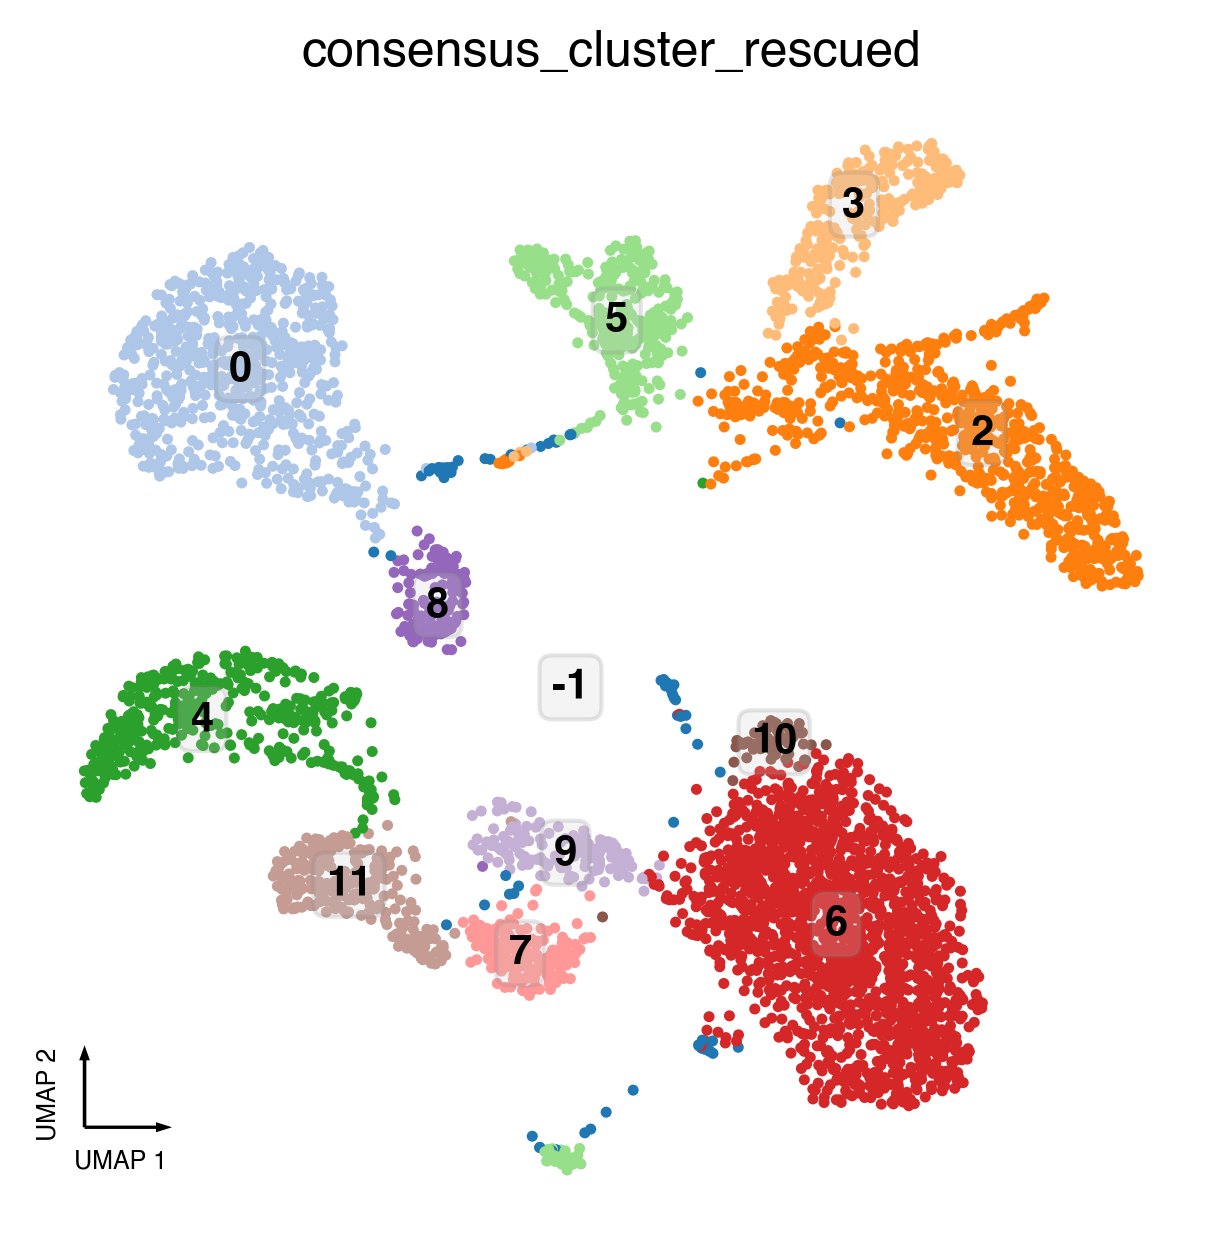

In [10]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, ncols=1)
categorical_scatter(data=cell_tidy_data,
                    coord_base=coord_base,
                    ax=ax,
                    hue=cluster_col_name,
                    palette='tab20',
                    text_anno=cluster_col_name)
ax.set(title=cluster_col_name)

## Plot Genes

In [11]:
total_cell_meta = pd.read_csv('cell_meta.csv', index_col=0)
cell_tidy_data['mCH_rate'] = total_cell_meta['mCH_rate']
cell_tidy_data['mCG_rate'] = total_cell_meta['mCG_rate']

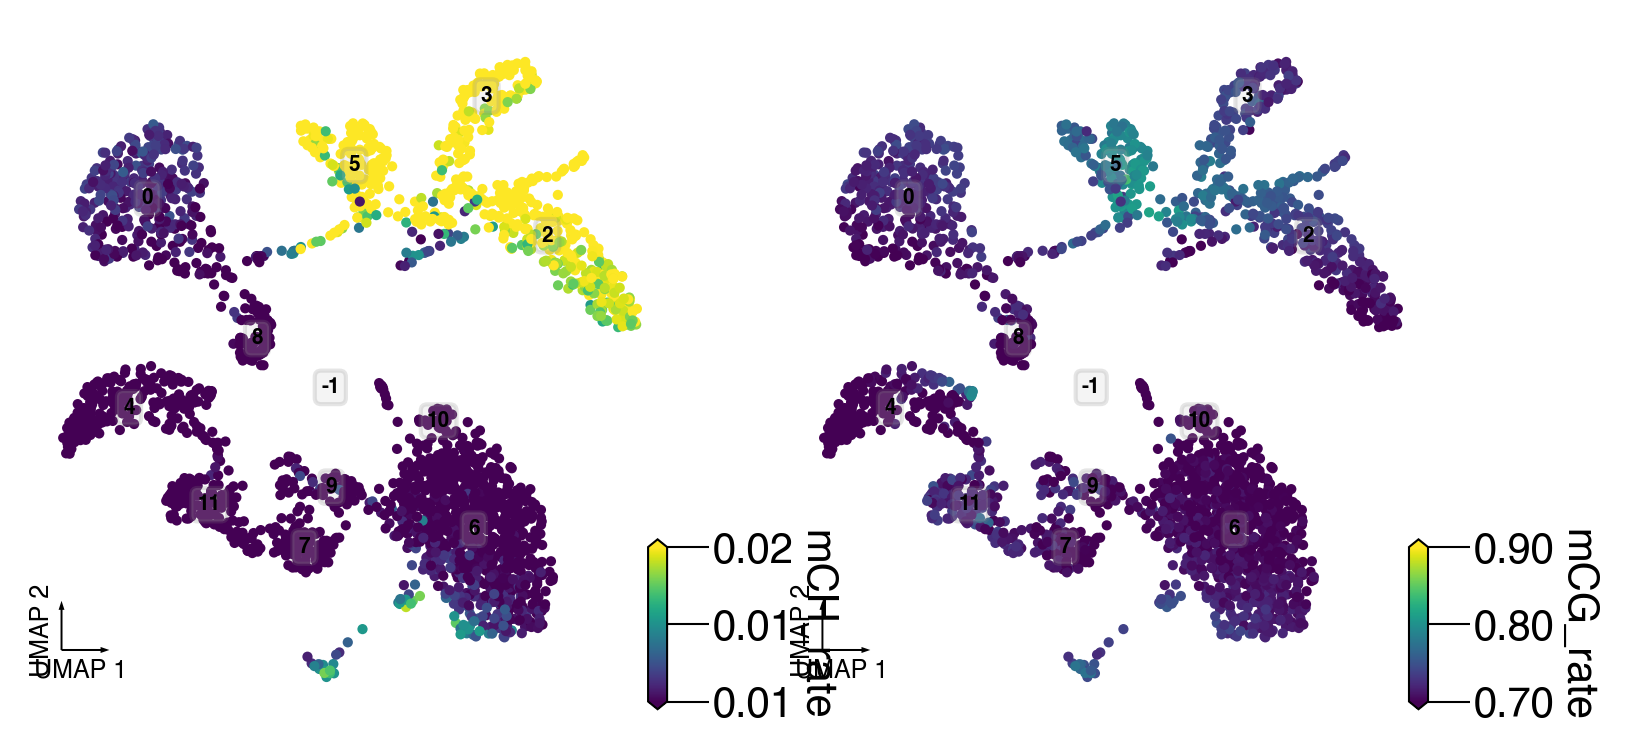

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize=(6, 3), nrows=1, ncols=2, dpi=300)

ax = ax1
continuous_scatter(cell_tidy_data,
                   ax,
                   coord_base=coord_base,
                   hue='mCH_rate',
                   hue_norm=(0.01, 0.02),
                   text_anno=cluster_col_name,
                   scatter_kws=dict(s=6),
                   text_anno_kws=dict(fontsize=5),
                   max_points=2500)

ax = ax2
continuous_scatter(cell_tidy_data,
                   ax,
                   coord_base=coord_base,
                   hue='mCG_rate',
                   hue_norm=(0.7, 0.9),
                   text_anno=cluster_col_name,
                   scatter_kws=dict(s=6),
                   text_anno_kws=dict(fontsize=5),
                   max_points=2500)
# fig.savefig(fig_dir / f'{gene_name}_{mc_type}_Cluster_Marker.pdf')
pass

### Single Gene

Text(0.5, 1.0, 'Peak1')

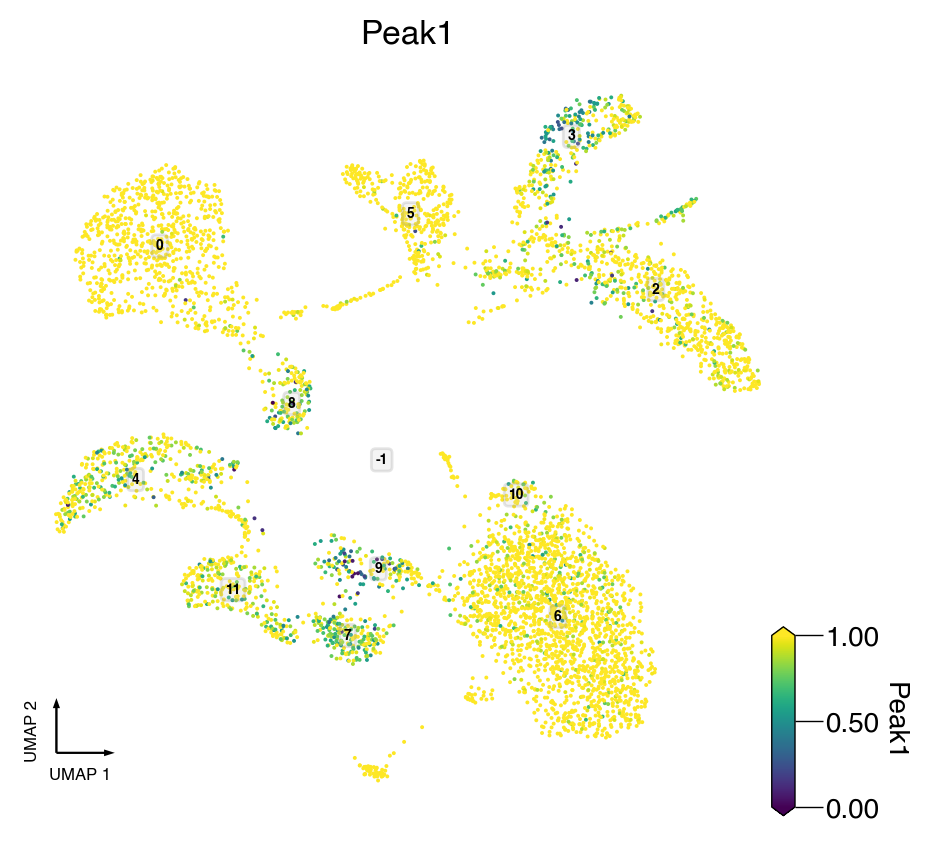

In [13]:
gene_name = 'Peak1'

gene_id = gene_name_to_id[gene_name]
fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1, dpi=200)
if gene_name not in cell_tidy_data.columns:
    cell_tidy_data[gene_name] = get_gene_data(gene_id)
continuous_scatter(cell_tidy_data,
                   ax,
                   coord_base=coord_base,
                   hue=gene_name,
                   hue_norm=(0, 1),
                   text_anno=cluster_col_name,
                   scatter_kws=dict(s=2),
                   text_anno_kws=dict(fontsize=5),
                   max_points=10000)
ax.set_title(gene_name)
# fig.savefig(fig_dir / f'{gene_name}_{mc_type}_Cluster_Marker.pdf')

In [14]:
cell_tidy_data['consensus_cluster_rescued'].value_counts()

 6     1805
 2      824
 0      744
 4      444
 5      372
 3      301
 11     267
 7      201
 9      152
 8      144
-1       84
 10      60
Name: consensus_cluster_rescued, dtype: int64

## Manual Annotation

In [15]:
cell_tidy_data[cluster_col_name].value_counts()

 6     1805
 2      824
 0      744
 4      444
 5      372
 3      301
 11     267
 7      201
 9      152
 8      144
-1       84
 10      60
Name: consensus_cluster_rescued, dtype: int64

In [16]:
{i:'' for i in sorted(cell_tidy_data[cluster_col_name].unique())}

{-1: '',
 0: '',
 2: '',
 3: '',
 4: '',
 5: '',
 6: '',
 7: '',
 8: '',
 9: '',
 10: '',
 11: ''}

In [17]:
cluster_name_map = {-1: 'Neuron',
 0: 'NonNeuron',
 2: 'Neuron',
 3: 'Neuron',
 4: 'NonNeuron',
 5: 'Neuron',
 6: 'Neuron',
 7: 'NonNeuron',
 8: 'NonNeuron',
 9: 'NonNeuron',
 10: 'Neuron',
 11: 'NonNeuron'}
cluster_name_map

{-1: 'Neuron',
 0: 'NonNeuron',
 2: 'Neuron',
 3: 'Neuron',
 4: 'NonNeuron',
 5: 'Neuron',
 6: 'Neuron',
 7: 'NonNeuron',
 8: 'NonNeuron',
 9: 'NonNeuron',
 10: 'Neuron',
 11: 'NonNeuron'}

In [18]:
raw_cell_tidy_data[cluster_col_name + "_anno"] = cell_tidy_data[cluster_col_name].apply(lambda i: cluster_name_map[i] if i in cluster_name_map else i)

In [19]:
raw_cell_tidy_data.to_msgpack('cell_tidy_data.final_annotation.msg')

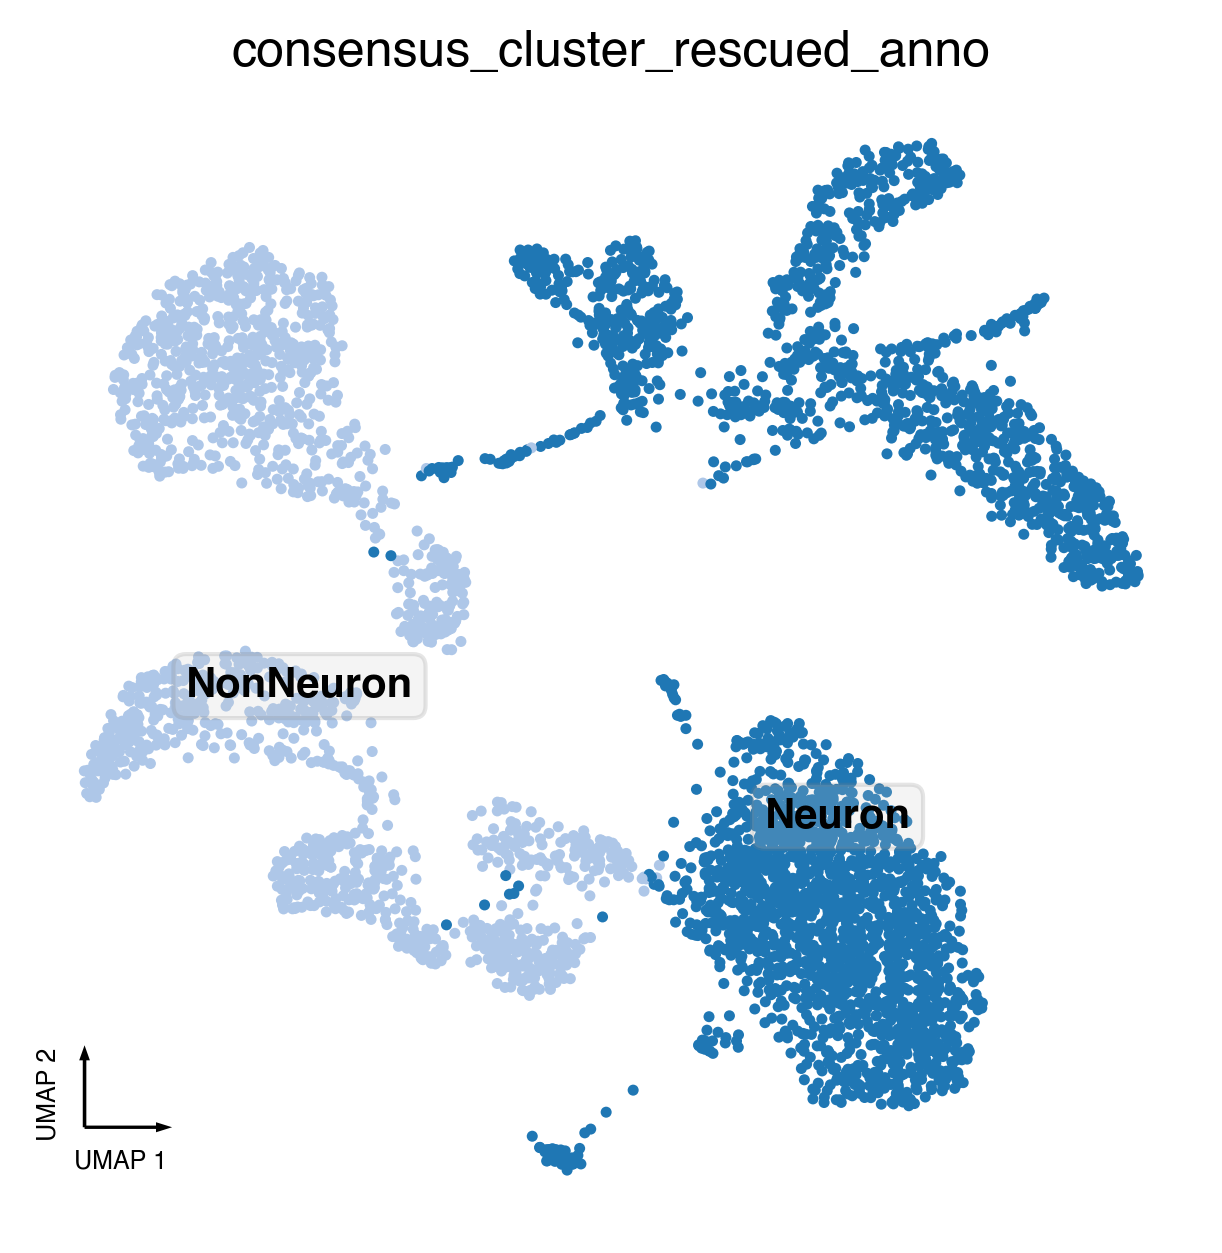

In [20]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, ncols=1)
categorical_scatter(data=raw_cell_tidy_data,
                    coord_base=coord_base,
                    ax=ax,
                    hue=cluster_col_name + "_anno",
                    palette='tab20',
                    text_anno=cluster_col_name + "_anno")
ax.set(title=cluster_col_name + "_anno")
fig.savefig(fig_dir / 'FinalClusterAnno.pdf')